In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial on Tilt-Bound

The Tilt-Bound is the newest bound on Type I Error.
This notebook aims to provide the simplest example on using the Tilt-Bound in `confirm`.
The Tilt-Bound comes in two variations: forward and backward.
The forward mode is used as part of the "validation" step where it computes the bound directly
given the Type I Error at the simulation point.
The backward mode is used as part of the "tuning" step where it computes the inverted forward bound
given the desired Type I Error in the tile.

For this tutorial, we will focus on Binomial family since it is one of the most useful applications
and requires non-trivial implementation to compute these bounds.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
from functools import partial
import matplotlib.pyplot as plt
import pyimprint.grid as pygrid
import confirm.imprint.grid as grid
from confirm.imprint.bound import binomial as binomial

## Validation Step

Consider $n$ (size parameter of Binomial family), 
$\theta_0$ (logit parameter of Binomial family) simulation point, and
a set of $v \in H-\theta_0$ that describe the vertices of a rectangle
where $H$ is the rectangular tile associated with $\theta_0$.
Suppose that the test has a Type I Error of $f(\theta_0)$.

In [8]:
n = 350  # size
theta_0 = np.array([-1.0, 0.0, 0.5])  # sim point
f0 = 0.01  # Type I Error at theta_0

# Create corners of the tile with a given max radius.
radius = 0.1
v_coords = [[-1.0, 1.0]] * theta_0.shape[0]
mgrid = np.meshgrid(*v_coords, indexing="ij")
vs = radius * np.concatenate([coord.reshape(-1, 1) for coord in mgrid], axis=1)

We can compute the forward Tilt-Bound by calling `tilt_bound_fwd_tile` with the above information and the hyperparameter $q$.

In [11]:
binomial.tilt_bound_fwd_tile(
    q=2.5,
    n=n,
    theta_0=theta_0,
    vs=vs,
    f0=f0,
)

DeviceArray(0.39291623, dtype=float32)

However, note that the bound is incredibly sensitive to the $q$-value.
In the above, we manually found a $q$ that provides decent performance,
but if we changed $q$ to a different value, the bound could potentially explode.

In [16]:
binomial.tilt_bound_fwd_tile(
    q=10,
    n=n,
    theta_0=theta_0,
    vs=vs,
    f0=f0,
)

DeviceArray(1127.0117, dtype=float32)

For this reason, we provide a JAX-based class `TileForwardQCPSolver` that optimizes for $q$
based on the other inputs.

In [80]:
fwd_solver = binomial.TileForwardQCPSolver(n=n, tol=1e-6)
q_opt = fwd_solver.solve(theta_0=theta_0, vs=vs, a=f0)  # optimal q
q_opt

DeviceArray(1.9399352, dtype=float32)

As a sanity check, we can plot the bound as a function of $q$ and check that the optimal $q$
indeed achieves the minimum value.

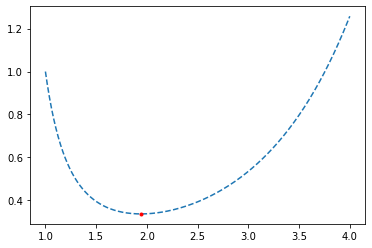

In [19]:
def _sanity_check_fwd_solver():
    q_grid = np.linspace(1 + 1e-6, 4, 1000)
    bound_vmap = jax.vmap(
        binomial.tilt_bound_fwd_tile, in_axes=(0, None, None, None, None)
    )
    bounds = bound_vmap(q_grid, n, theta_0, vs, f0)
    opt_bound = binomial.tilt_bound_fwd_tile(q_opt, n, theta_0, vs, f0)
    plt.plot(q_grid, bounds, "--")
    plt.plot(q_opt, opt_bound, "r.")


_sanity_check_fwd_solver()

### Main Workflow

The main workflow is to apply this technique in parallel on many tiles.
For each tile (and its corresponding simulation point),
we would like to optimize for $q$ based on the worst corner.

The following is an example of a workflow.
We start with an array of simulation points `thetas` and the radius that defines the boundaries of the rectangular tile `radii`.
For this example, we are using the helper function `make_cartesian_grid_range`, but any `thetas, radii` will do.
The vertices for each tile are explicitly computed using `radii`.
Assume that we have access to the Type I Error values at each of the `thetas`.

In [97]:
# TODO: fix
# gr = pygrid.make_cartesian_grid_range(
#     size=100,
#     lower=-np.ones(2),
#     upper=np.ones(2),
#     grid_sim_size=0,  # dummy for now
# )
# thetas = gr.thetas().T
# subset = thetas[:, 0] >= thetas[:, 1]
# thetas = thetas[subset]
# radii = gr.radii().T
# radii = radii[subset]

# # dummy function to output TIE of a simple test.
# def simple_TIE(n, theta, alpha):
#     prob = scipy.special.expit(theta)
#     var = np.sum(n * prob * (1 - prob), axis=-1)
#     mean = n * (prob[:, 1] - prob[:, 0]) / np.sqrt(var)
#     z_crit = scipy.stats.norm.isf(alpha)
#     return scipy.stats.norm.sf(z_crit - mean)


# f0s = simple_TIE(n, thetas, 0.025)

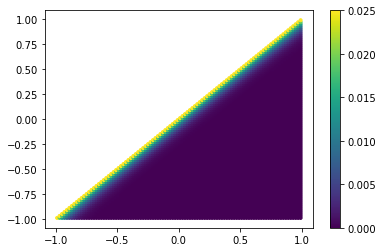

In [98]:
sc = plt.scatter(thetas[:, 0], thetas[:, 1], c=f0s, marker=".")
plt.colorbar(sc)

In [99]:
hypercube = grid.hypercube_vertices(
    thetas.shape[1],
)
make_vertices = jax.vmap(
    lambda r: r * hypercube,
    in_axes=(0,),
)
vertices = make_vertices(radii)

Finally, we vectorize the routine from before to get the best bound for the worse corner for each tile.

In [100]:
def tilt_bound_fwd_tile_opt(n, t, v, f0, fwd_solver):
    q_opt = fwd_solver.solve(t, v, f0)
    return q_opt, binomial.tilt_bound_fwd_tile(q_opt, n, t, v, f0)


tilt_bound_fwd_tile_jvmap = jax.jit(
    jax.vmap(
        lambda n, t, v, f0: tilt_bound_fwd_tile_opt(n, t, v, f0, fwd_solver)[-1],
        in_axes=(None, 0, 0, 0),
    )
)

In [105]:
bounds = tilt_bound_fwd_tile_jvmap(
    n,
    thetas,
    vertices,
    f0s,
)

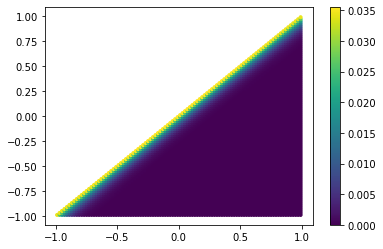

In [106]:
sc = plt.scatter(thetas[:, 0], thetas[:, 1], c=bounds, marker=".")
plt.colorbar(sc)

## Tuning Step 

In the tuning step, we invert the Tilt-Bound and optimize a different objective.
The inversion gives us a bound on the Type I Error at `theta_0` in order to achieve level alpha in the tile.
Intuitively, we would like this inverted bound to be as large as possible (less conservative).
Hence, the `q` parameter allows us to maximize the bound on a tile.

In [116]:
bwd_solver = binomial.TileBackwardQCPSolver(n=n)

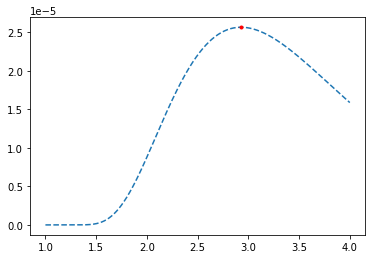

In [117]:
def _sanity_check_bwd_solver():
    q_grid = np.linspace(1 + 1e-6, 4, 1000)
    bound_vmap = jax.vmap(
        binomial.tilt_bound_bwd_tile, in_axes=(0, None, None, None, None)
    )
    bounds = bound_vmap(q_grid, n, theta_0, vs, f0)
    q_opt = bwd_solver.solve(theta_0, vs, f0)
    opt_bound = binomial.tilt_bound_bwd_tile(q_opt, n, theta_0, vs, f0)
    plt.plot(q_grid, bounds, "--")
    plt.plot(q_opt, opt_bound, "r.")


_sanity_check_bwd_solver()

### Main Workflow

The main workflow is similar to that of validation step.
For each tile (and its corresponding simulation point),
we would like to optimize for $q$ based on the worse corner
of the backward bound.

The following is an example of a workflow.
We continue with the setup as in validation step.

In [134]:
def tilt_bound_bwd_tile_opt(n, t, v, alpha, bwd_solver):
    q_opt = bwd_solver.solve(t, v, alpha)
    return q_opt, binomial.tilt_bound_bwd_tile(q_opt, n, t, v, alpha)


tilt_bound_bwd_tile_jvmap = jax.jit(
    jax.vmap(
        lambda n, t, v, alpha: tilt_bound_bwd_tile_opt(n, t, v, alpha, bwd_solver)[-1],
        in_axes=(None, 0, 0, 0),
    )
)

In [135]:
alphas = jnp.full(thetas.shape[0], 0.025)
bounds_bwd = tilt_bound_bwd_tile_jvmap(
    n,
    thetas,
    vertices,
    alphas,
)

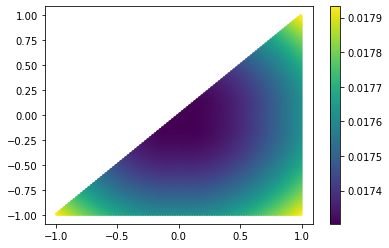

In [136]:
sc = plt.scatter(thetas[:, 0], thetas[:, 1], c=bounds_bwd, marker=".")
plt.colorbar(sc)